# Factorial Design

In [2]:
# 3d Dataframe test
import pandas as pd

indices = [['a', 'b'], ['c', 'd']]
multi_index = pd.MultiIndex.from_product(indices)

data = [[1, 2], [3, 4], [5, 6], [7, 8]]

df = pd.DataFrame(data, index=multi_index)
df

0  1
a c  1  2
  d  3  4
b c  5  6
  d  7  8

# By Hand

In [3]:
import pandas as pd

indices = [['mat_1', 'mat_2', 'mat_3'], ['15_deg', '70_deg', '125_deg']]
multi_index = pd.MultiIndex.from_product(indices)

data = [
    [130, 155, 74, 180], 
    [34, 40, 80, 75],
    [20, 70, 82, 58],
    [150, 188, 159, 126],
    [136, 122, 106, 115],
    [25, 70, 58, 45],
    [138, 110, 168, 160],
    [174, 120, 150, 139],
    [96, 104, 82, 60]
       ]

df = pd.DataFrame(data, index=multi_index, columns=[1, 2, 3, 4])
df

1    2    3    4
mat_1 15_deg   130  155   74  180
      70_deg    34   40   80   75
      125_deg   20   70   82   58
mat_2 15_deg   150  188  159  126
      70_deg   136  122  106  115
      125_deg   25   70   58   45
mat_3 15_deg   138  110  168  160
      70_deg   174  120  150  139
      125_deg   96  104   82   60

In [4]:
a = len(df.index.levels[0])
b = len(df.index.levels[1])
n = len(df.columns)

grand_total = df.sum().sum()
a_totals = df.groupby(level=0).sum().sum(axis=1).values
b_totals = df.groupby(level=1).sum().sum(axis=1).values
cell_totals = df.sum(axis=1).values

print(a, b, n, grand_total, a_totals, b_totals, cell_totals)

3 3 4 3799 [ 998 1300 1501] [ 770 1738 1291] [539 229 230 623 479 198 576 583 342]


In [5]:
ss_t = sum([i**2 for i in df.values.flatten()]) - (grand_total**2)/(a*b*n)
ss_a = sum([i**2 for i in a_totals])/(b*n) - (grand_total**2)/(a*b*n)
ss_b = sum([i**2 for i in b_totals])/(a*n) - (grand_total**2)/(a*b*n)
ss_axb = sum([i**2 for i in cell_totals])/n - (grand_total**2)/(a*b*n) - ss_a - ss_b
ss_e = ss_t - ss_a - ss_b - ss_axb

print(ss_t, ss_a, ss_b, ss_axb, ss_e)

77646.9722222 10683.7222222 39118.7222222 9613.77777778 18230.75


In [6]:
dof_a = a - 1 
dof_b = b - 1
dof_axb = dof_a*dof_b
dof_e = a*b*(n - 1)
dof_t = n*a*b - 1

dof_t == dof_a + dof_b + dof_axb + dof_e

True

In [7]:
mean_ss_t = ss_t/dof_t
mean_ss_a = ss_a/dof_a
mean_ss_b = ss_b/dof_b
mean_ss_axb = ss_axb/dof_axb
mean_ss_e = ss_e/dof_e

In [8]:
f_a = mean_ss_a/mean_ss_e
f_b = mean_ss_b/mean_ss_e
f_axb = mean_ss_axb/mean_ss_e
print('Material Type F0: ', f_a)
print('Temperature F0: ', f_b)
print('Interaction F0: ', f_axb)

Material Type F0:  7.91137226938
Temperature F0:  28.967691949
Interaction F0:  3.55953540035


# With statsmodels

In [9]:
data = [
    [130, 155, 74, 180], 
    [34, 40, 80, 75],
    [20, 70, 82, 58],
    [150, 188, 159, 126],
    [136, 122, 106, 115],
    [25, 70, 58, 45],
    [138, 110, 168, 160],
    [174, 120, 150, 139],
    [96, 104, 82, 60]
       ]

data = [item for l in data for item in l]
material = [1]*12 + [2]*12 + [3]*12
temp = [15]*4 + [70]*4 + [125]*4
temp = temp*3

df_life = pd.DataFrame({'Batt_Life': data, 'Mat_Type': material, 'Temp': temp})
df_life

,Batt_Life,Mat_Type,Temp
0,130,1,15
1,155,1,15
2,74,1,15
3,180,1,15
4,34,1,70
5,40,1,70
6,80,1,70
7,75,1,70
8,20,1,125
9,70,1,125


In [10]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
formula = ('Batt_Life ~ C(Mat_Type) + C(Temp) + C(Mat_Type):C(Temp)')
res = ols(formula, data=df_life).fit()
aov_table = anova_lm(res, typ=2)
print(aov_table)

                           sum_sq    df          F        PR(>F)
C(Mat_Type)          10683.722222   2.0   7.911372  1.976083e-03
C(Temp)              39118.722222   2.0  28.967692  1.908596e-07
C(Mat_Type):C(Temp)   9613.777778   4.0   3.559535  1.861117e-02
Residual             18230.750000  27.0        NaN           NaN


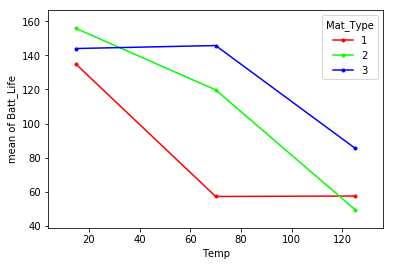

In [11]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(df_life.Temp, df_life.Mat_Type, df_life.Batt_Life)
plt.show()

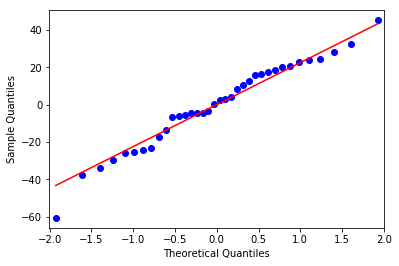

In [12]:
from statsmodels.graphics.gofplots import qqplot
resid = res.resid
fig = qqplot(resid, line='s')
plt.show()

# No repeated observations

In [13]:
data_imp = [
    [5, 4, 6, 3, 5], 
    [3, 1, 4, 2, 3],
    [1, 1, 3, 1, 2]
    ]

data_imp = [item for l in data_imp for item in l]
temp = [100]*5 + [125]*5 + [150]*5
pres = [25, 30, 35, 40, 45]
pres = pres*3

df_imp = pd.DataFrame({'Impurity': data_imp, 'Temp': temp, 'Pressure': pres})
df_imp

,Impurity,Pressure,Temp
0,5,25,100
1,4,30,100
2,6,35,100
3,3,40,100
4,5,45,100
5,3,25,125
6,1,30,125
7,4,35,125
8,2,40,125
9,3,45,125


In [14]:
formula = 'Impurity ~ C(Pressure) + C(Temp) + C(Temp):C(Pressure)'
res = ols(formula, data=df_imp).fit()
# aov_table = anova_lm(res, typ=2)
# print(aov_table)

# General Factorial Design

In [15]:
dev_drink = [-3, -1, -1, 0, 0, 1, 2, 1, 5, 4, 7, 6, -1, 0, 1, 1, 2, 3, 6, 5, 7, 9, 10, 11]
pres_drink = [25]*12 + [30]*12
speed_drink = [200, 200, 250, 250]*6
carb_drink = [10, 10, 10, 10, 12, 12, 12, 12, 14, 14, 14, 14]*2
df_dev = pd.DataFrame({'Fill_Dev': dev_drink, 'Pressure': pres_drink, 'Speed': speed_drink, 'Carbonation': carb_drink})
df_dev

,Carbonation,Fill_Dev,Pressure,Speed
0,10,-3,25,200
1,10,-1,25,200
2,10,-1,25,250
3,10,0,25,250
4,12,0,25,200
5,12,1,25,200
6,12,2,25,250
7,12,1,25,250
8,14,5,25,200
9,14,4,25,200


In [16]:
# main_effects = 'C(Carbonation) + C(Pressure) + C(Speed)'
# double_effects = ' + C(Carbonation):C(Pressure) + C(Pressure):C(Speed) + C(Speed):C(Carbonation)'
# triple_effects = ' + C(Carbonation):C(Pressure):C(Speed)'
# formula = 'Fill_Dev ~ ' + main_effects + double_effects + triple_effects
formula = 'Fill_Dev ~ C(Carbonation)*C(Pressure)*C(Speed)'

model = ols(formula, data=df_dev).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                                         sum_sq    df           F  \
C(Carbonation)                       252.750000   2.0  178.411765   
C(Pressure)                           45.375000   1.0   64.058824   
C(Speed)                              22.041667   1.0   31.117647   
C(Carbonation):C(Pressure)             5.250000   2.0    3.705882   
C(Carbonation):C(Speed)                0.583333   2.0    0.411765   
C(Pressure):C(Speed)                   1.041667   1.0    1.470588   
C(Carbonation):C(Pressure):C(Speed)    1.083333   2.0    0.764706   
Residual                               8.500000  12.0         NaN   

                                           PR(>F)  
C(Carbonation)                       1.186249e-09  
C(Pressure)                          3.742257e-06  
C(Speed)                             1.202174e-04  
C(Carbonation):C(Pressure)           5.580812e-02  
C(Carbonation):C(Speed)              6.714939e-01  
C(Pressure):C(Speed)                 2.485867e-01  
C(Carbonation)

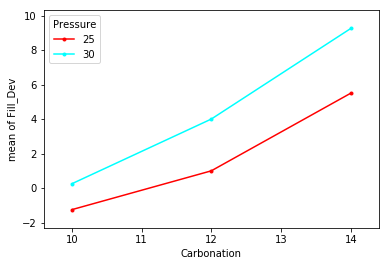

In [17]:
fig = interaction_plot(df_dev.Carbonation, df_dev.Pressure, df_dev.Fill_Dev)
plt.show()

In [18]:
df_dev.groupby('Speed').Fill_Dev.mean()

Speed
200    2.166667
250    4.083333
Name: Fill_Dev, dtype: float64

In [19]:
df_dev.groupby('Pressure').Fill_Dev.mean()

Pressure
25    1.75
30    4.50
Name: Fill_Dev, dtype: float64

# Response Curves

In [20]:
df_life.columns
df_life['Temp2'] = df_life.Temp**2

In [21]:
import math
formula = 'Batt_Life ~ C(Mat_Type)*Temp+ C(Mat_Type)*I(Temp**2)'
model = ols(formula, data=df_life).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                                sum_sq    df         F    PR(>F)
C(Mat_Type)               10683.722222   2.0  7.911372  0.001976
Temp                       1239.179404   1.0  1.835242  0.186738
C(Mat_Type):Temp           7170.660365   2.0  5.309925  0.011357
I(Temp ** 2)                 76.055556   1.0  0.112639  0.739753
C(Mat_Type):I(Temp ** 2)   7298.694444   2.0  5.404735  0.010612
Residual                  18230.750000  27.0       NaN       NaN


In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Batt_Life   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     11.00
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           9.43e-07
Time:                        08:57:53   Log-Likelihood:                -163.17
No. Observations:                  36   AIC:                             344.3
Df Residuals:                      27   BIC:                             358.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       169.3802     20.568      8.235      0.000     127.179     211.582
C(Mat_Type)[T.2]                 -9.7562     29.087     -0.335      0.740     -69.438      49.926
C(Mat_Type)[T.3]                -36.6178     29.087     -1.259      0.219     -96.299      23.064
Temp                             -2.5014      0.755     -3.313      0.003      -4.051      -0.952
C(Mat_Type)[T.2]:Temp             2.3281      1.068      2.180      0.038       0.137       4.519
C(Mat_Type)[T.3]:Temp             3.4043      1.068      3.188      0.004       1.213       5.596
I(Temp ** 2)                      0.0129      0.005      2.443      0.021       0.002       0.024
C(Mat_Type)[T.2]:I(Temp ** 2)    -0.0185      0.007     -2.488      0.019      -0.034      -0.003
C(Mat_Type)[T.3]:I(Temp ** 2)    -0.0231      0.007     -3.105      0.004      -0.038      -0.008
==============================================================================
Omnibus:                        1.609   Durbin-Watson:                   2.713
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.192
Skew:                          -0.444   Prob(JB):                        0.551
Kurtosis:                       2.922   Cond. No.                     9.68e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.68e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

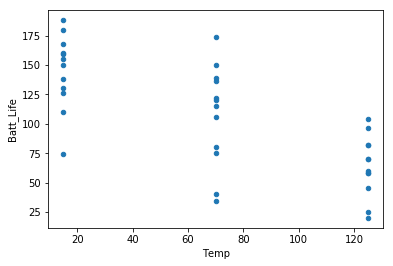

In [23]:
df_life.plot.scatter('Temp', 'Batt_Life')
plt.show()

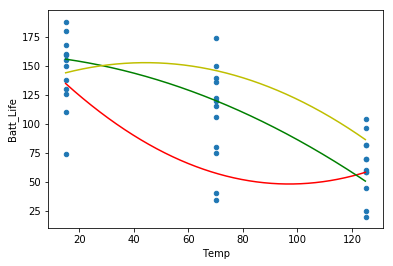

In [24]:
import numpy as np
x = np.arange(15, 125, .1)
y_1 = [(lambda a: 169.2803 - 2.5014*a + .0129*(a**2))(a) for a in x]
y_2 = [(lambda a: 169.2803  -9.7562 - 2.5014*a + 2.3281*a + .0129*(a**2) - .0185*(a**2))(a) for a in x]
y_3 = [(lambda a: 169.2803  -36.6178 - 2.5014*a + 3.4043*a + .0129*(a**2) - 0.0231*(a**2))(a) for a in x]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(x, y_1, 'r')
ax1.plot(x, y_2, 'g')
ax1.plot(x, y_3, 'y')
df_life.plot.scatter('Temp', 'Batt_Life', ax=ax1)
plt.show()

# Problem 5.9

In [27]:
force_data = [2.7, 2.78, 2.83, 2.86, 2.45, 2.49, 2.85, 2.8, 2.6, 2.72, 2.86, 2.87, 2.75, 2.86, 2.94, 2.88]
speed_data = [125, 125, 200, 200]*4
feed_data = [.015]*4 + [.03]*4 + [.045]*4 + [.06]*4

df_drill = pd.DataFrame({'Force': force_data, 'Speed': speed_data, 'Feed': feed_data})
df_drill.head()


,Feed,Force,Speed
0,0.015,2.70,125
1,0.015,2.78,125
2,0.015,2.83,200
3,0.015,2.86,200
4,0.030,2.45,125


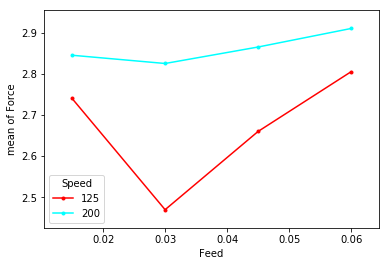

In [31]:
fig = interaction_plot(df_drill.Feed, df_drill.Speed, df_drill.Force)
plt.show()

In [35]:
formula = 'Force ~ C(Feed)*C(Speed)'
model = ols(formula, df_drill).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                    sum_sq   df          F    PR(>F)
C(Feed)           0.092500  3.0  11.858974  0.002582
C(Speed)          0.148225  1.0  57.009615  0.000066
C(Feed):C(Speed)  0.041875  3.0   5.368590  0.025567
Residual          0.020800  8.0        NaN       NaN


All factors appear to be significant in affecting the thrust force.
At high drill speed, there is 3.5x less variance than at low speed.

In [45]:
df_drill.groupby('Speed').describe().Force*2

,count,mean,std,min,25%,50%,75%,max
Speed,,,,,,,,
125,16.0,5.3375,0.286543,4.9,5.145,5.42,5.515,5.72
200,16.0,5.7225,0.081020,5.6,5.690,5.72,5.745,5.88


In [49]:
# df_drill[df_drill.Speed == 200]
formula = 'Force ~ C(Feed)'
model = ols(formula, df_drill[df_drill.Speed == 200]).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

            sum_sq   df         F    PR(>F)
C(Feed)   0.007938  3.0  2.981221  0.159391
Residual  0.003550  4.0       NaN       NaN


Feed has no significant impact at high drill speeds, only at low drill speed.

# Problem 5.25

In [86]:
current_data = [4.6, 4.4, 3.2, 3.5, 10.15, 10.2, 9.38, 10.02, 11.01, 10.58, 10.81, 10.6]
doping_data = [1e20, 1e20, 2e20, 2e20]*3
temp_data = [900]*4 + [950]*4 + [1000]*4

df_doping = pd.DataFrame({'Current': current_data, 'Doping': doping_data, 'Temp': temp_data})
df_doping.head()

,Current,Doping,Temp
0,4.60,1.000000e+20,900
1,4.40,1.000000e+20,900
2,3.20,2.000000e+20,900
3,3.50,2.000000e+20,900
4,10.15,1.000000e+20,950


In [87]:
formula = 'Current ~ C(Doping)*C(Temp)'
model = ols(formula, df_doping).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                       sum_sq   df           F        PR(>F)
C(Doping)            0.980408  1.0   15.257295  7.928350e-03
C(Temp)            111.187917  2.0  865.163403  4.126286e-08
C(Doping):C(Temp)    0.575817  2.0    4.480482  6.450226e-02
Residual             0.385550  6.0         NaN           NaN


In [95]:
model.summary()

/home/shlapo/.anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Current   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     350.9
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.59e-07
Time:                        09:51:50   Log-Likelihood:                 3.6007
No. Observations:                  12   AIC:                             4.799
Df Residuals:                       6   BIC:                             7.708
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -962.0550     79.141    -12.156      0.000   -1155.706    -768.404
C(Doping)[T.2e+20]                -62.8900    111.922     -0.562      0.595    -336.754     210.974
Temp                                1.9839      0.167     11.889      0.000       1.576       2.392
C(Doping)[T.2e+20]:Temp             0.1208      0.236      0.512      0.627      -0.457       0.698
I(Temp ** 2)                       -0.0010   8.78e-05    -11.513      0.000      -0.001      -0.001
C(Doping)[T.2e+20]:I(Temp ** 2)   -5.8e-05      0.000     -0.467      0.657      -0.000       0.000
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   2.689
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.357
Skew:                          -0.000   Prob(JB):                        0.837
Kurtosis:                       2.156   Cond. No.                     1.82e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

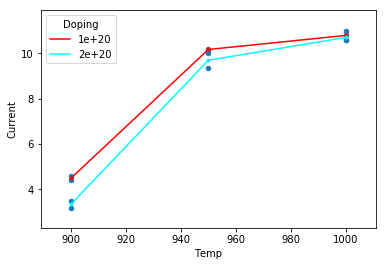

In [89]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

interaction_plot(df_doping.Temp, df_doping.Doping, df_doping.Current, ax=ax1)
df_doping.plot.scatter('Temp', 'Current', ax=ax1)
plt.show()

In [90]:
formula = 'Current ~ C(Doping)*Temp + C(Doping)*I(Temp**2)'
model = ols(formula, df_doping).fit()
aov_table = anova_lm(model, typ=2)
print(aov_table)

                           sum_sq   df           F    PR(>F)
C(Doping)                0.980408  1.0   15.257292  0.007928
Temp                    19.288983  1.0  300.178693  0.000002
C(Doping):Temp           0.016839  1.0    0.262051  0.627004
I(Temp ** 2)            18.026667  1.0  280.534302  0.000003
C(Doping):I(Temp ** 2)   0.014017  1.0    0.218130  0.656947
Residual                 0.385550  6.0         NaN       NaN


In [91]:
model.summary()

/home/shlapo/.anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Current   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     350.9
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.59e-07
Time:                        09:51:10   Log-Likelihood:                 3.6007
No. Observations:                  12   AIC:                             4.799
Df Residuals:                       6   BIC:                             7.708
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        -962.0550     79.141    -12.156      0.000   -1155.706    -768.404
C(Doping)[T.2e+20]                -62.8900    111.922     -0.562      0.595    -336.754     210.974
Temp                                1.9839      0.167     11.889      0.000       1.576       2.392
C(Doping)[T.2e+20]:Temp             0.1208      0.236      0.512      0.627      -0.457       0.698
I(Temp ** 2)                       -0.0010   8.78e-05    -11.513      0.000      -0.001      -0.001
C(Doping)[T.2e+20]:I(Temp ** 2)   -5.8e-05      0.000     -0.467      0.657      -0.000       0.000
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   2.689
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.357
Skew:                          -0.000   Prob(JB):                        0.837
Kurtosis:                       2.156   Cond. No.                     1.82e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

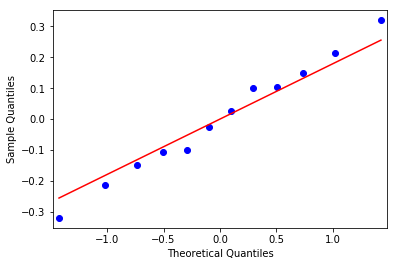

In [101]:
resid = model.resid
fig = qqplot(resid, line='s')
plt.show()

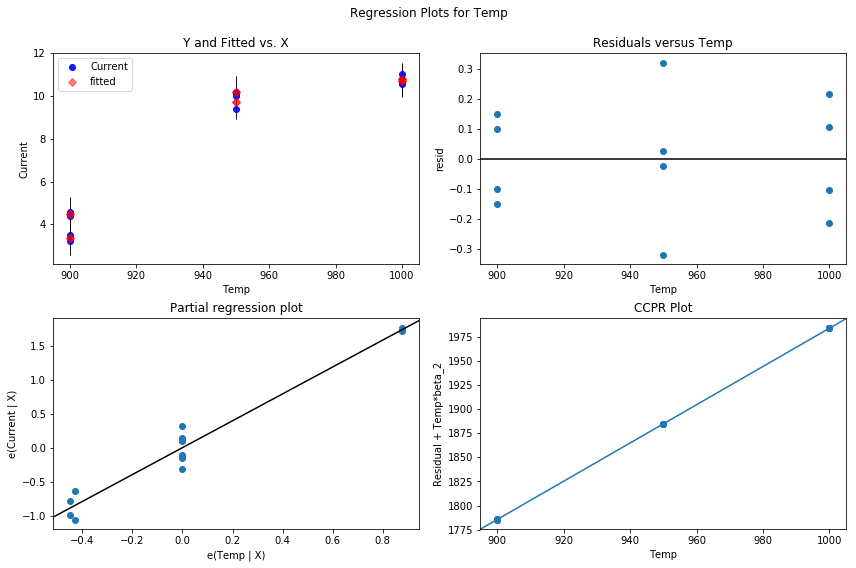

In [102]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "Temp", fig=fig)
plt.show()